In [1]:
import keras
import matplotlib.pyplot as plt
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def __init__(self, plot_interval=1, evaluate_interval=10, x_val=None, y_val_categorical=None):
        self.plot_interval = plot_interval
        self.evaluate_interval = evaluate_interval
        self.x_val = x_val
        self.y_val_categorical = y_val_categorical
        #self.model = model
    
    def on_train_begin(self, logs={}):
        print('Begin training')
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []
    
    def on_epoch_end(self, epoch, logs={}):
        if self.evaluate_interval is None:
            self.logs.append(logs)
            self.x.append(self.i)
            self.losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))
            self.acc.append(logs.get('acc'))
            self.val_acc.append(logs.get('val_acc'))
            self.i += 1
        
        if (epoch%self.plot_interval==0):
            clear_output(wait=True)
            f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(20,5))
            ax1.plot(self.x, self.losses, label="loss")
            ax1.plot(self.x, self.val_losses, label="val_loss")
            ax1.legend()

            ax2.plot(self.x, self.acc, label="acc")
            ax2.plot(self.x, self.val_acc, label="val_acc")
            ax2.legend()
            plt.show();
        #score = self.model.evaluate(x_test, y_test_categorical, verbose=0)
        
        #print("accuracy: ", score[1])
    
    def on_batch_end(self, batch, logs={}):
        if self.evaluate_interval is not None:
            if (batch%self.evaluate_interval==0):
                self.i += 1
                self.logs.append(logs)
                self.x.append(self.i)
                self.losses.append(logs.get('loss'))
                self.acc.append(logs.get('acc'))

                if self.x_val is not None:
                    score = self.model.evaluate(self.x_val, self.y_val_categorical, verbose=0)
                    self.val_losses.append(score[0])
                    self.val_acc.append(score[1])

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
folder = './data/'
x = np.load(folder+'train_images.npy')
y = np.loadtxt(folder+'train_labels.csv', delimiter=',', skiprows=1)
x_test = np.load(folder+'test_images.npy')

In [4]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.1)

In [5]:
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import initializers
from keras import regularizers

In [6]:
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_valid)

print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

(54000, 28, 28)
(6000, 28, 28)
(10000, 28, 28)


(54000, 784)
(6000, 784)
(10000, 784)


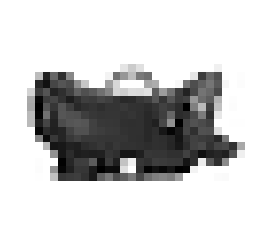

In [7]:
# PREPROCESAMIENTO
x_train_reshaped = x_train.reshape(54000,784)
x_valid_reshaped = x_valid.reshape(6000,784)
x_test_reshaped = x_test.reshape(10000,784)

print(x_train_reshaped.shape)
print(x_valid_reshaped.shape)
print(x_test_reshaped.shape)

# veamos alguna imagen al azar
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = x_train_reshaped[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, 
           cmap = matplotlib.cm.binary, 
           interpolation = "nearest")
plt.axis("off")
plt.show()

(54000, 187)
(6000, 187)
(10000, 187)


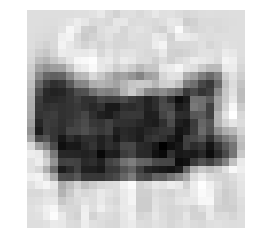

In [8]:
from  sklearn.decomposition import PCA

pca = PCA(n_components = 0.95)

x_train_final = pca.fit_transform(x_train_reshaped)
x_valid_final = pca.transform(x_valid_reshaped)
x_test_final = pca.transform(x_test_reshaped)

print(x_train_final.shape)
print(x_valid_final.shape)
print(x_test_final.shape)

# reconstruyo la imagen para ver que info se perdió
x_recovered = pca.inverse_transform(x_train_final)

some_digit = x_recovered[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, 
           cmap = matplotlib.cm.binary, 
           interpolation = "nearest")
plt.axis("off")
plt.show()

(54000, 187)
(6000, 187)
(10000, 187)


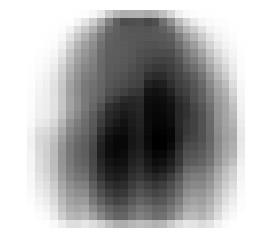

In [9]:
# STANDARIZACION DE FEATURES
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_final = scaler.fit_transform(x_train_final)
x_valid_final = scaler.transform(x_valid_final)
x_test_final = scaler.transform(x_test_final)

print(x_train_final.shape)
print(x_valid_final.shape)
print(x_test_final.shape)

# reconstruyo la imagen para ver que info se perdió
x_recovered = pca.inverse_transform(x_train_final)

some_digit = x_recovered[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, 
           cmap = matplotlib.cm.binary, 
           interpolation = "nearest")
plt.axis("off")
plt.show()

In [10]:
input_features = 187
output_size = 10
hidden_units = 1024
hidden_units_2 = 512
hidden_units_3 = 512
hidden_units_4 = 256
hidden_units_5 = 128
lambd = 0#0.001
prob = 0.25
initializer = 'he_normal'

# Creo el modelo
model = Sequential()

# capa de entrada
#model.add(Flatten(input_shape=x_train.shape[1:]))

# capa oculta 1
model.add(Dense(hidden_units,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer=initializer, name="Capa_Oculta_1"))
model.add(BatchNormalization())
model.add(Activation('elu', name="output_capa_oculta_1")) 
model.add(Dropout(prob))

# capa oculta 2
model.add(Dense(hidden_units_2,input_dim=hidden_units, kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer=initializer,name="Capa_Oculta_2"))
model.add(BatchNormalization())
model.add(Activation('elu', name="output_capa_oculta_2")) 
model.add(Dropout(prob))

# capa oculta 3
model.add(Dense(hidden_units_3,input_dim=hidden_units_2, kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer=initializer, name="Capa_Oculta_3"))
model.add(BatchNormalization())
model.add(Activation('elu', name="output_capa_oculta_3")) 
model.add(Dropout(prob))

# capa oculta 4
model.add(Dense(hidden_units_4,input_dim=hidden_units_3, kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer=initializer, name="Capa_Oculta_4"))
model.add(BatchNormalization())
model.add(Activation('elu', name="output_capa_oculta_4")) 
model.add(Dropout(prob))

# capa oculta 5
model.add(Dense(hidden_units_5,input_dim=hidden_units_4, kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer=initializer, name="Capa_Oculta_5"))
model.add(BatchNormalization())
model.add(Activation('elu', name="output_capa_oculta_5")) 
model.add(Dropout(prob))

# capa de salida
model.add(Dense(output_size,input_dim=hidden_units_5, kernel_initializer=initializer, name='Salida'))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Oculta_1 (Dense)        (None, 1024)              192512    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
output_capa_oculta_1 (Activa (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
Capa_Oculta_2 (Dense)        (None, 512)               524800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
output_capa_oculta_2 (Activa (None, 512)               0         
__________

In [11]:
# Compilo el modelo
lr = 0.001
optimizer = optimizers.adam(lr=lr)
model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [12]:
# Callbacks
## Callback para graficar
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=50, x_val=x_valid_final, y_val_categorical=y_val_categorical)
## Callback para guardar pesos
checkpointer = ModelCheckpoint(filepath='single-layer.mnist.hdf5', verbose=1, save_best_only=True)

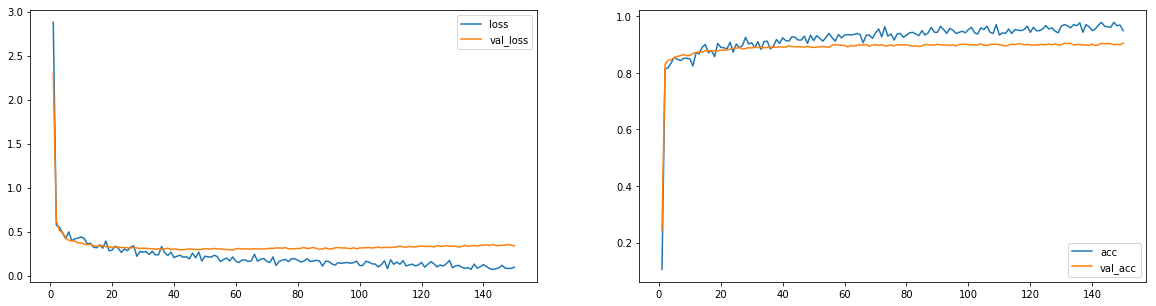

Epoch 00049: val_loss did not improve
54000/54000 [==============================] - 21s - loss: 0.0997 - acc: 0.9615 - val_loss: 0.3405 - val_acc: 0.9032


In [13]:
batch_size = 512
model.fit(x_train_final, 
          y_train_categorical,
          epochs=50, batch_size=batch_size, 
          verbose=1, 
          validation_data = (x_valid_final, y_val_categorical),
          callbacks=[plot_losses, checkpointer],
         )


In [14]:
loss, acc = model.evaluate(x_valid_final, y_val_categorical)

5952/6000 [============================>.] - ETA: 0s

In [15]:
print(acc)

0.9031666666666667


In [16]:
test_prediction = model.predict(x_test_final)
test_labels = np.argmax(test_prediction, axis = 1)

In [17]:
import pandas
df = pandas.DataFrame(data={"Category": test_labels}).astype(int)
df.to_csv("./submission_jnf.csv", sep=',',index=True,  index_label='Id')

In [ ]:
# TEST ACC: 0.89566